# Анализ оттока клиентов фитнес клуба

#### Обучим модель прогнозировать вероятнаость оттока;
#### Выделим целевые группы клиентов для маркетингова отдела;<br>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder

### Загрузим данные

In [2]:
df = pd.read_csv('gym_dataset.csv')

In [3]:
df.head(10)

,Pool,Personal_coach,Friend_invite,Phone,Subscription_mth,Class_visits,Age,Revenue_mth,Lifetime,AVG_class_mth,Churn_rate,Gender
0,1,1,0,############,1,No,32,2599,0,2,1,Male
1,1,1,1,############,6,No,34,7094,1,0,0,Male
2,1,1,1,############,1,Yes,33,2682,9,0,0,Male
3,1,0,1,############,1,Yes,27,952,5,1,0,Male
4,1,0,0,############,1,No,34,2966,0,3,1,Female
5,1,0,0,############,1,No,30,5748,3,1,1,Male
6,1,0,0,############,12,Yes,28,4760,13,2,0,Male
7,1,0,0,############,6,Yes,36,6279,4,2,0,Male
8,1,1,1,############,6,No,32,2425,16,3,0,Female
9,1,0,0,############,12,No,34,2357,2,1,0,Male


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Pool              3647 non-null   int64 
 1   Personal_coach    3647 non-null   int64 
 2   Friend_invite     3647 non-null   int64 
 3   Phone             3301 non-null   object
 4   Subscription_mth  3647 non-null   int64 
 5   Class_visits      3647 non-null   object
 6   Age               3647 non-null   int64 
 7   Revenue_mth       3647 non-null   int64 
 8   Lifetime          3647 non-null   int64 
 9   AVG_class_mth     3647 non-null   int64 
 10  Churn_rate        3647 non-null   int64 
 11  Gender            3647 non-null   object
dtypes: int64(9), object(3)
memory usage: 342.0+ KB


Преобразуем строковые значения колонок Class_visits, Phone, Gender  в бинарные, пропущеные значения телефоном заполним нулями <br>
Проще всего сделать через map

In [5]:
df['Gender'] = df['Gender'].map({'Female':1, 'Male':0}).astype('int64')
df = df.fillna('0')
df['Phone'] = df['Phone'].map({'############':1, '0':0}).astype('int64')

Но можно и LabelEncoder использовать

In [6]:
encoder =  LabelEncoder()
df['Class_visits'] = encoder.fit_transform(df['Class_visits']).astype('int64') # 0 = No, 1 = Yes

In [7]:
df

,Pool,Personal_coach,Friend_invite,Phone,Subscription_mth,Class_visits,Age,Revenue_mth,Lifetime,AVG_class_mth,Churn_rate,Gender
0,1,1,0,1,1,0,32,2599,0,2,1,0
1,1,1,1,1,6,0,34,7094,1,0,0,0
2,1,1,1,1,1,1,33,2682,9,0,0,0
3,1,0,1,1,1,1,27,952,5,1,0,0
4,1,0,0,1,1,0,34,2966,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3642,1,1,0,1,12,0,36,77,8,2,0,1
3643,1,0,0,1,1,1,32,2204,1,0,1,0
3644,1,1,1,1,12,0,31,2504,2,2,0,1
3645,1,1,1,1,6,0,35,1981,3,1,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Pool              3647 non-null   int64
 1   Personal_coach    3647 non-null   int64
 2   Friend_invite     3647 non-null   int64
 3   Phone             3647 non-null   int64
 4   Subscription_mth  3647 non-null   int64
 5   Class_visits      3647 non-null   int64
 6   Age               3647 non-null   int64
 7   Revenue_mth       3647 non-null   int64
 8   Lifetime          3647 non-null   int64
 9   AVG_class_mth     3647 non-null   int64
 10  Churn_rate        3647 non-null   int64
 11  Gender            3647 non-null   int64
dtypes: int64(12)
memory usage: 342.0 KB


In [9]:
df.describe()

,Pool,Personal_coach,Friend_invite,Phone,Subscription_mth,Class_visits,Age,Revenue_mth,Lifetime,AVG_class_mth,Churn_rate,Gender
count,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000
mean,0.845627,0.488072,0.309021,0.905128,4.694818,0.414587,32.170551,4698.683301,3.744173,1.307102,0.264601,0.511379
std,0.361356,0.499926,0.462153,0.293079,4.555603,0.492718,3.269312,3080.903447,3.774365,1.032926,0.441181,0.499939
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,30.000000,2218.500000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,32.000000,4365.000000,3.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,34.000000,6730.000000,5.000000,2.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,44.000000,17683.000000,31.000000,6.000000,1.000000,1.000000


In [10]:
df.query('Churn_rate == "1"').describe()

,Pool,Personal_coach,Friend_invite,Phone,Subscription_mth,Class_visits,Age,Revenue_mth,Lifetime,AVG_class_mth,Churn_rate,Gender
count,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.0,965.000000
mean,0.765803,0.360622,0.183420,0.908808,1.759585,0.269430,29.978238,3637.907772,0.992746,0.636269,1.0,0.507772
std,0.423715,0.480430,0.387211,0.288031,2.190659,0.443894,2.891995,2466.585633,1.111497,0.728303,0.0,0.500199
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,5.000000,0.000000,0.000000,1.0,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,1616.000000,0.000000,0.000000,1.0,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,30.000000,3262.000000,1.000000,1.000000,1.0,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,32.000000,5253.000000,1.000000,1.000000,1.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,13617.000000,9.000000,3.000000,1.0,1.000000


Четверть отваливается, не мало

#### Разделим датасет на дискретные и неприрывные признаки

In [11]:
not_bin_list = ['Revenue_mth', 'Age', 'Lifetime', 'AVG_class_mth', 'Subscription_mth']
bin_list = ['Pool', 'Personal_coach', 'Friend_invite', 'Phone', 'Class_visits', 'Gender']

In [12]:
dfgp = df.groupby('Churn_rate').agg(['mean']).reset_index().droplevel(1, axis=1) 
dfgp

,Churn_rate,Pool,Personal_coach,Friend_invite,Phone,Subscription_mth,Class_visits,Age,Revenue_mth,Lifetime,AVG_class_mth,Gender
0,0,0.874348,0.533930,0.354213,0.903803,5.750932,0.466816,32.959359,5080.356823,4.734154,1.548471,0.512677
1,1,0.765803,0.360622,0.183420,0.908808,1.759585,0.269430,29.978238,3637.907772,0.992746,0.636269,0.507772


На основании сгруппированых данных можно отметить, что наличие тренера или товарища в клубе благоприятно сказываются на клиентах, а вот "новичкам" взявшим месяц на "попробовать" тяжело видимо втянуться и они отваливаются.

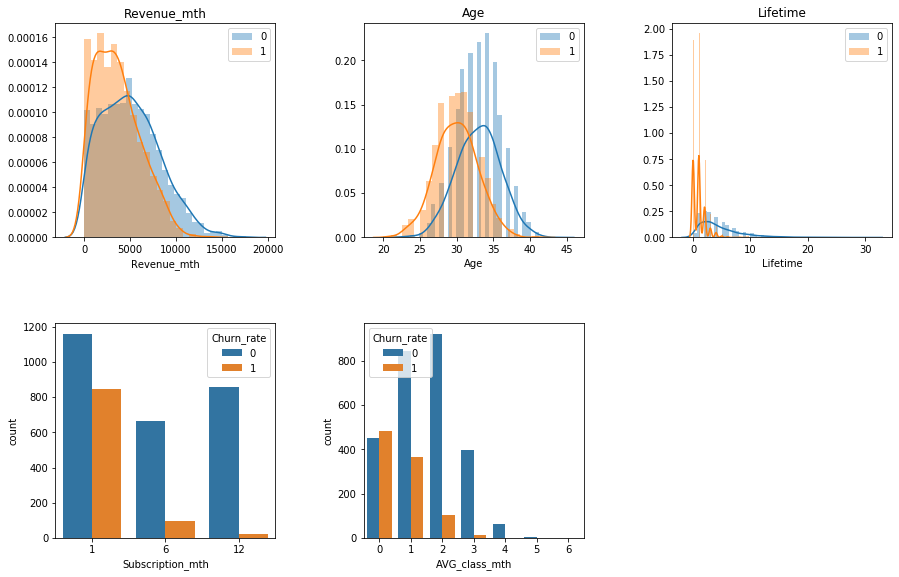

In [13]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 4):
    ax = fig.add_subplot(3, 3, i), sns.distplot(df.query('Churn_rate == "0"')[not_bin_list[i-1]], kde=True),
    sns.distplot(df.query('Churn_rate == "1"')[not_bin_list[i-1]], kde=True),
    plt.legend(labels=['0','1'])
    plt.title(label=not_bin_list[i-1])
ax = fig.add_subplot(3, 3, 4), sns.countplot(x="Subscription_mth", hue="Churn_rate", data=df)
ax = fig.add_subplot(3, 3, 5), sns.countplot(x="AVG_class_mth", hue="Churn_rate", data=df)

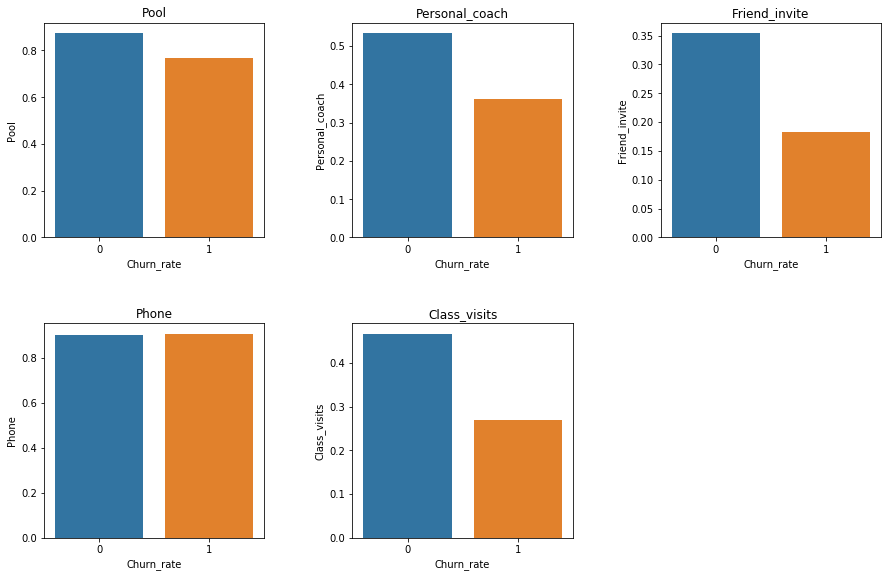

In [14]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 6):
    ax = fig.add_subplot(3, 3, i), sns.barplot(x="Churn_rate", y=dfgp[bin_list[i-1]], data=dfgp)
    plt.title(label=bin_list[i-1])

Посмотрим на матрицу корреляяций

In [15]:
cm = df.corr()

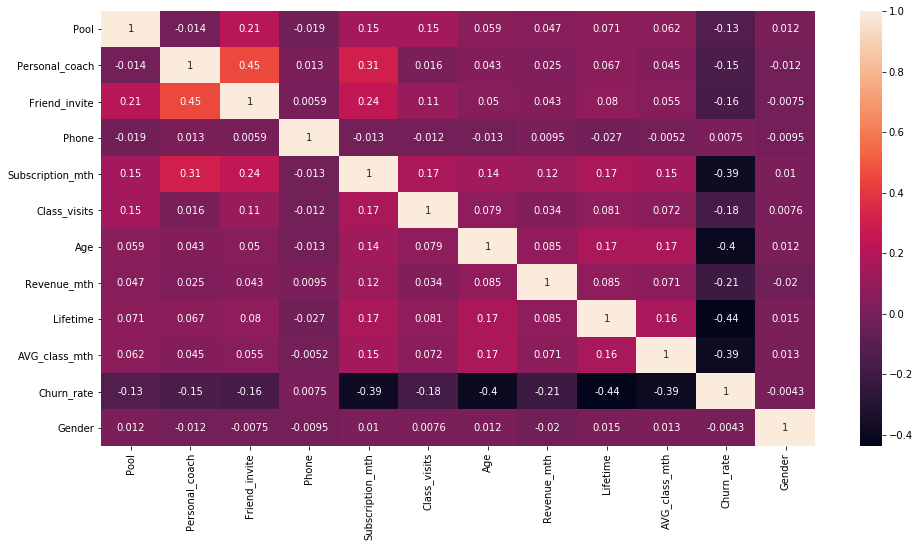

In [16]:
plt.figure(figsize = (16,8))
sns.heatmap(cm, annot = True)

## Построим модель прогнозирования оттока пользователей

Разобьем данные на обучающую и валидационную выборку функцией train_test_split().

In [17]:
X = df.drop(['Churn_rate'], axis=1)
y = df['Churn_rate']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные

In [19]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Проведем прогнозирование на основе трех различных моделей

In [20]:
model = LogisticRegression(random_state=0)
# обучим модель
model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
predictions = model.predict(X_test_st)

In [22]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.79


In [23]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
rf_predictions = rf_model.predict(X_test_st)

In [25]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.89
Precision: 0.81
Recall: 0.77


In [26]:
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state=0)
gb_model.fit(X_train_st, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [27]:
gb_pred = gb_model.predict(X_test_st)

In [28]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, gb_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, gb_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, gb_pred)))

Accuracy: 0.90
Precision: 0.83
Recall: 0.77


## Проведем кластеризацию

Избавимся от признака оттока, номера телефона и стандартизируем данные

In [29]:
df_nc = df.drop(columns=['Churn_rate', 'Phone']) # наличие телефона захламляет кластеры

In [30]:
scaler = StandardScaler() 
x_sc = scaler.fit_transform(df_nc)

Построим матрицу расстояний функцией linkage()

In [31]:
linked = linkage(x_sc, method = 'ward')

И дендрограмму

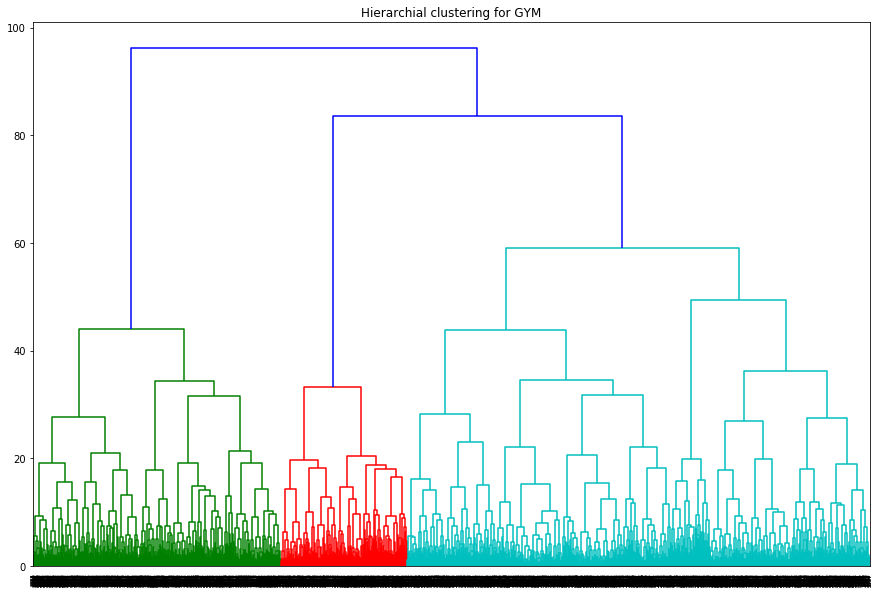

In [32]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

In [33]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

In [34]:
df_nc['cluster_km'] = labels
df_nc['Churn_rate'] = df['Churn_rate']

In [35]:
df_gp = df_nc.groupby('cluster_km').agg('mean').reset_index()
df_gp

,cluster_km,Pool,Personal_coach,Friend_invite,Subscription_mth,Class_visits,Age,Revenue_mth,Lifetime,AVG_class_mth,Gender,Churn_rate
0,0,0.997703,0.931087,0.744257,7.683767,0.517611,32.707504,5087.903522,4.698315,1.493874,0.493874,0.101838
1,1,0.000000,0.501786,0.076786,3.078571,0.239286,31.694643,4353.801786,3.087500,1.150000,0.494643,0.403571
2,2,1.000000,0.158899,0.062886,3.011230,0.394161,31.926446,4521.710837,3.250983,1.219540,0.529478,0.340258


In [36]:
df_nc.groupby('cluster_km').agg('count')['Age']

cluster_km
0    1306
1     560
2    1781
Name: Age, dtype: int64

Кластеризация с n>5 дает нам два лишние кластера. n4 - выделяет в отдельный кластер клиентов, не указавших мобильный телефон(может быть и техническим сбоем) и полностью дублирует средние значения признаков всей выборки. n5 - выделяет дополнительный кластер poll == 0

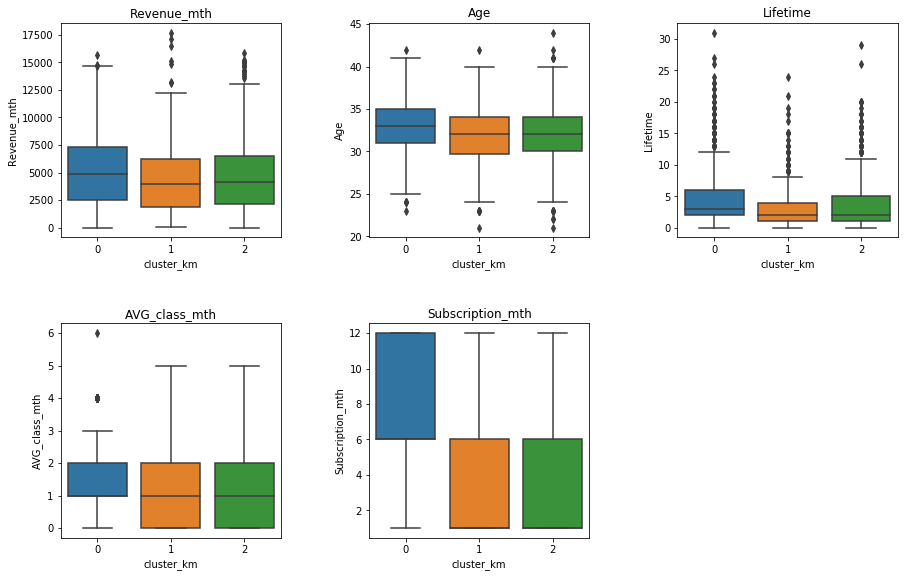

In [37]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 6):
    ax = fig.add_subplot(3, 3, i), sns.boxplot(x="cluster_km", y=df_nc[not_bin_list[i-1]], data=df_nc)
    plt.title(label=not_bin_list[i-1])

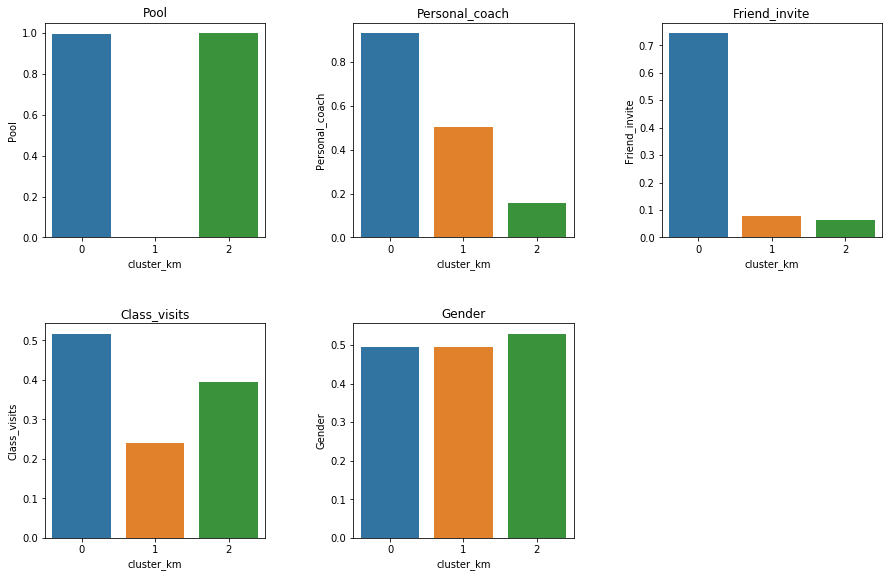

In [38]:
bin_list.remove('Phone')
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 6):
    ax = fig.add_subplot(3, 3, i), sns.barplot(x="cluster_km", y=df_gp[bin_list[i-1]], data=df_gp)
    plt.title(label=bin_list[i-1])